In this notebook, we will try to train an LSTM model using API-Calls from android applications.

<h1>Loading Data</h1>

<h1>Regular Run Start</h1>
Up from here, you can find the necessary code to prepare the data to train using API-Calls.
For convenience, here on out we will use the already exported data.

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# Read the CSV file
df = pd.read_csv('api_calls_labeled_dataset.csv')

2024-07-21 19:52:17.248324: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-21 19:52:17.501325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 19:52:17.563881: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 19:52:17.579899: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-21 19:52:17.681633: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = df[df['detection'] != 'ransomware']
df = df[df['detection'] != 'rootkit']
df = df[df['detection'] != 'other']

benign_samples = df[df['detection'] == 'benign'].sample(n=1000, replace=True)
other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop=True)
df = pd.concat([benign_samples, other_samples]).reset_index(drop=True)
df['detection'].value_counts()

/tmp/ipykernel_9109/2932402478.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  other_samples = df[df['detection'] != 'benign'].groupby('detection').apply(lambda x: x.sample(n=200, replace=True)).reset_index(drop=True)


detection
benign      1000
adware       200
exploit      200
hacktool     200
spyware      200
trojan       200
Name: count, dtype: int64

In [3]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the labels
labels = label_encoder.fit_transform(df['detection'])

# Tokenize the API call sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['api_calls'])

# Convert sequences to numerical representations
sequences = tokenizer.texts_to_sequences(df['api_calls'])

# Define the maximum sequence length
max_seq_length = 500

# Pad the sequences
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')


In [4]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)


Training set shape: (1600, 500)
Validation set shape: (400, 500)
Training labels shape: (1600,)
Validation labels shape: (400,)


<h1>Training LSTM</h1>

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_seq_length))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/home/kreunt/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1721580749.237599    9109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721580749.358874    9109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721580749.358921    9109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721580749.362014    9109 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1721580749.362088    91

In [6]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/10


2024-07-21 19:52:33.069039: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.4490 - loss: 1.6291 - val_accuracy: 0.6025 - val_loss: 1.1087
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - accuracy: 0.5893 - loss: 1.0464 - val_accuracy: 0.6975 - val_loss: 0.8244
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.7221 - loss: 0.6867 - val_accuracy: 0.7125 - val_loss: 0.7818
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8465 - loss: 0.4543 - val_accuracy: 0.8025 - val_loss: 0.6106
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9069 - loss: 0.2914 - val_accuracy: 0.8525 - val_loss: 0.5730
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9436 - loss: 0.1974 - val_accuracy: 0.8550 - val_loss: 0.5487
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9680 - loss: 0.1237 - val_accuracy: 0.8275 - val_loss: 0.6038
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9717 - loss: 0.1087 - val_accuracy: 0.8750 - val_loss: 0

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Predict on the validation set
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

# Generate a classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))



Validation Loss: 0.6561107635498047
Validation Accuracy: 0.8525000214576721
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Classification Report:
              precision    recall  f1-score   support

      adware       0.57      0.82      0.67        34
      benign       0.91      0.94      0.93       199
     exploit       0.82      0.82      0.82        33
    hacktool       1.00      0.95      0.98        44
     spyware       0.85      0.73      0.79        48
      trojan       1.00      0.50      0.67        42

   micro avg       0.87      0.85      0.86       400
   macro avg       0.86      0.80      0.81       400
weighted avg       0.89      0.85      0.86       400
 samples avg       0.85      0.85      0.85       400



/home/kreunt/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


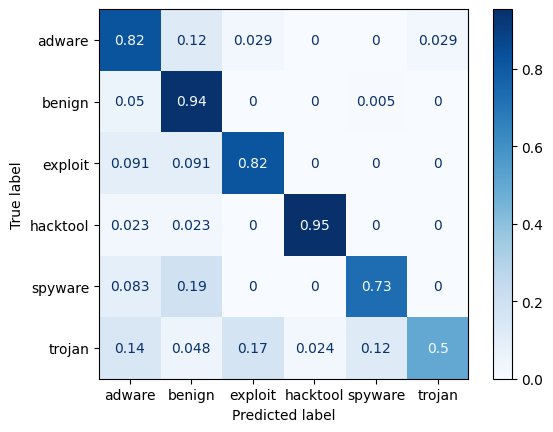

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_true and y_pred are in class index format
y_true = np.argmax(y_val, axis=1)  # Convert one-hot encoded labels to class indices
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert predicted probabilities to class indices


# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')



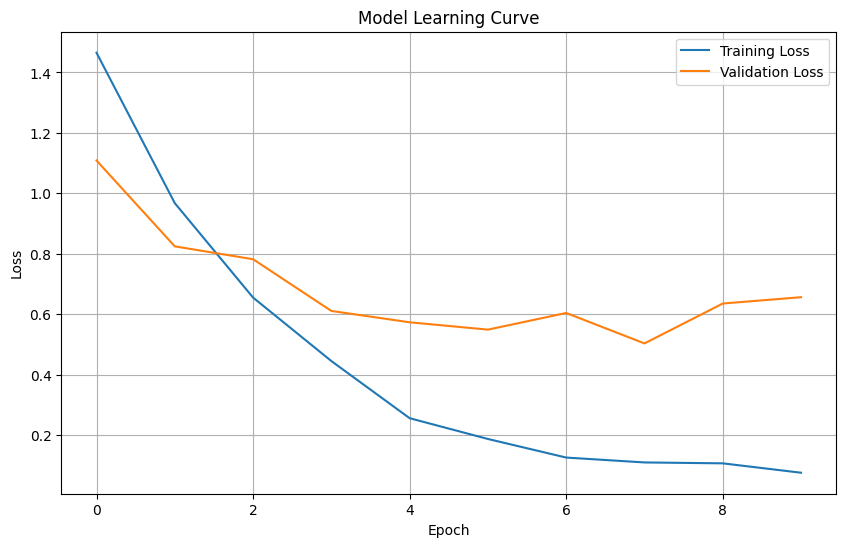

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


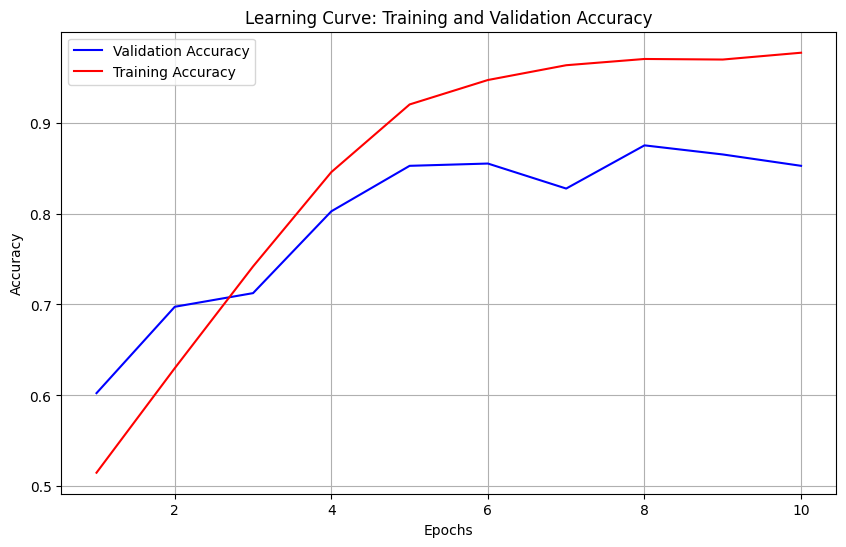

In [10]:
# Extract validation and training accuracy from history
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_accuracy) + 1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(epochs, val_accuracy, 'b-', label='Validation Accuracy')
plt.plot(epochs, train_accuracy, 'r-', label='Training Accuracy')
plt.title('Learning Curve: Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
model.save('lstm_api_calls_200each1000benign.keras')